<a href="https://colab.research.google.com/github/Joonyoung-Song/DACON-NLP_competition/blob/main/Bidirectional_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from matplotlib import rcParams, pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import re
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, GlobalMaxPooling1D, Conv1D, Dropout, Bidirectional,GRU
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam
from nltk.tokenize import word_tokenize
import warnings
import gensim 

import os
warnings.filterwarnings(action='ignore')

In [4]:
tf.__version__

'2.3.0'

In [5]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

## 학습데이터 로드

In [6]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [7]:
data_dir = Path('/gdrive/My Drive/dacon_nlp_competition/data')
feature_dir = Path('/gdrive/My Drive/dacon_nlp_competition/build/feature')
val_dir = Path('/gdrive/My Drive/dacon_nlp_competition/build/val')
tst_dir = Path('/gdrive/My Drive/dacon_nlp_competition/build/tst')
sub_dir = Path('/gdrive/My Drive/dacon_nlp_competition/build/sub')

trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test_x.csv'
sample_file = data_dir / 'sample_submission.csv'

target_col = 'author'
n_fold = 5
n_class = 5
seed = 42

In [8]:
algo_name = 'LSTM'
feature_name = 'emb'
model_name = f'{algo_name}_{feature_name}'

feature_file = feature_dir / f'{feature_name}.csv'
p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
sub_file = sub_dir / f'{model_name}.csv'

In [85]:
train = pd.read_csv(trn_file, encoding = 'utf-8',index_col=0)
train.head()

,text,author
index,,
0,"He was almost choking. There was so much, so m...",3
1,"“Your sister asked for it, I suppose?”",2
2,"She was engaged one day as she walked, in per...",1
3,"The captain was in the porch, keeping himself ...",4
4,"“Have mercy, gentlemen!” odin flung up his han...",3


In [86]:
test = pd.read_csv(tst_file, encoding = 'utf-8',index_col=0)
test.head()

,text
index,
0,“Not at all. I think she is one of the most ch...
1,"""No,"" replied he, with sudden consciousness, ""..."
2,As the lady had stated her intention of scream...
3,“And then suddenly in the silence I heard a so...
4,His conviction remained unchanged. So far as I...


## Preprocessing

## 불용어 제거

In [77]:
#알파벳과 숫자를 제외한 나머지 제거
def alpha_num(text):
    return re.sub(r'[^A-Za-z0-9 ]', '', text)

#불용어 제거
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stopwords:
            final_text.append(i.strip())
    return " ".join(final_text)

stopwords = [
            #  "the"
            #  "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", 
            #  "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", 
            #  "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", 
            #  "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", 
            #  "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", 
            #  "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", 
            #  "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", 
            #  "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", 
            #  "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", 
            #  "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", 
            #  "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" 
             ]

In [87]:
#작가 분류이기 때문에 불용어를 제거 하지 않는 것이 성능향상에 도움됨

# train['text'] = train['text'].str.lower()
# test['text'] = test['text'].str.lower()
train['text'] = train['text'].apply(alpha_num)
# .apply(remove_stopwords)
test['text'] = test['text'].apply(alpha_num)
# .apply(remove_stopwords)

In [88]:
X_train = train['text'].values
X_test = test['text'].values
y = train['author'].values
print(X_train.shape, X_test.shape, y.shape)

(54879,) (19617,) (54879,)


## Training

In [89]:
max_length = 500
vocab_size = 20000
embedding_dim = 32
padding_type='post'

In [90]:
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

In [91]:
len(word_index)

47256

In [92]:
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

In [93]:
pd.DataFrame(train_sequences).shape

(54879, 468)

In [94]:
trn = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)
tst = pad_sequences(test_sequences, padding=padding_type, maxlen=max_length)
print(trn.shape, tst.shape)

(54879, 500) (19617, 500)


In [95]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

In [96]:
import tensorflow as tf
tf.random.set_seed(seed)
np.random.seed(seed)

In [111]:
def get_model():    
    #  with tf.device('/device:GPU:0'):  
        model = Sequential([
            Embedding(vocab_size, embedding_dim, input_length=max_length),
            # Embedding(47256, 300, weights=[embedding_matrix], input_length=max_length, trainable=False),
            Bidirectional(GRU(16, return_sequences=True)),
            # Dropout(0.1),
            Bidirectional(GRU(16)),
            Dense(n_class, activation='softmax')
        ])

        model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=.01))
        return model

In [112]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    clf = get_model()
    
    es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=2,
                       verbose=1, mode='min', baseline=None, restore_best_weights=True)
    
    # rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
    #                     patience=3, min_lr=1e-6, mode='min', verbose=1)

    clf.fit(trn[i_trn], 
            to_categorical(y[i_trn]),
            validation_data=(trn[i_val], to_categorical(y[i_val])),
            epochs=10,
            callbacks=[es
                      #  ,rlr
                       ]
            )
    p_val[i_val, :] = clf.predict(trn[i_val])
    p_tst += clf.predict(tst) / n_fold

training model for CV #1
Epoch 1/10
1372/1372 [==============================] - 104s 76ms/step - loss: 0.9047 - val_loss: 0.6746
Epoch 2/10
1372/1372 [==============================] - 103s 75ms/step - loss: 0.5723 - val_loss: 0.7265
Epoch 3/10
1372/1372 [==============================] - 104s 76ms/step - loss: 0.4276 - val_loss: 0.7536
Epoch 00003: early stopping
training model for CV #2
Epoch 1/10
1372/1372 [==============================] - 104s 76ms/step - loss: 0.8948 - val_loss: 0.6930
Epoch 2/10
1372/1372 [==============================] - 102s 75ms/step - loss: 0.5360 - val_loss: 0.9053
Epoch 3/10
1372/1372 [==============================] - 103s 75ms/step - loss: 0.5892 - val_loss: 0.8053
Epoch 00003: early stopping
training model for CV #3
Epoch 1/10
1372/1372 [==============================] - 103s 75ms/step - loss: 0.9201 - val_loss: 0.7236
Epoch 2/10
1372/1372 [==============================] - 103s 75ms/step - loss: 0.5176 - val_loss: 0.6756
Epoch 3/10
1372/1372 [=======

In [113]:
print(f'Accuracy (CV): {accuracy_score(y, np.argmax(p_val, axis=1)) * 100:8.4f}%')
print(f'Log Loss (CV): {log_loss(pd.get_dummies(y), p_val):8.4f}')

Accuracy (CV):  74.7554%
Log Loss (CV):   0.6856


In [114]:
algo_name = 'GRU'
feature_name = 'emb'
algo_logloss = f'{log_loss(pd.get_dummies(y), p_val):8.4f}'
model_name = f'{algo_name}_{feature_name}_{algo_logloss}'

feature_file = feature_dir / f'{feature_name}.csv'
p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
sub_file = sub_dir / f'{model_name}.csv'

np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

## 시각화

In [ ]:
# model summary
print(clf.summary())

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 220, 64)           1280000   
_________________________________________________________________
bidirectional_23 (Bidirectio (None, 220, 128)          66048     
_________________________________________________________________
bidirectional_24 (Bidirectio (None, 128)               98816     
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 645       
Total params: 1,445,509
Trainable params: 1,445,509
Non-trainable params: 0
_________________________________________________________________
None


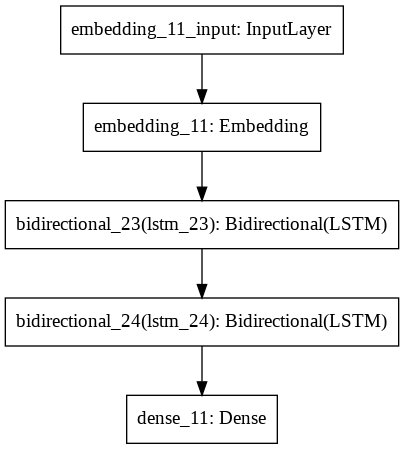

In [ ]:
plot_model(clf)

## 제출 파일 생성


In [115]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(19617, 5)


,0,1,2,3,4
index,,,,,
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0


In [116]:
sub[sub.columns] = p_tst
sub.head()

,0,1,2,3,4
index,,,,,
0,0.0190,0.3676,0.5267,0.0693,0.0175
1,0.2290,0.6384,0.0212,0.0277,0.0837
2,0.9691,0.0188,0.0041,0.0011,0.0069
3,0.0319,0.0044,0.7783,0.0063,0.1791
4,0.8185,0.0570,0.0242,0.0808,0.0195


In [117]:
sub.to_csv(sub_file)